## PROGRAM TO DESIGN FOUNDATIONS SUPPORTED BY RIGID INCLUSIONS

### Design Information

#### Provide the information below for design

In [2]:
import numpy as np
# Input Parameters
column_size = (2.0, 5.0)  # Column dimensions (x, y) in ft
column_eccentricity = (0.0, 0)  # Eccentricity of column from center (x, y) in ft
column_centroid = (7.5, 7.5)  # center of the column in ft
pile_cap_thickness = 3.167  # Pile cap thickness in ft
pile_embedment = 1.0  # Depth of pile embedment in pile cap (ft)
soil_depth_above = 2.0  # Soil depth above pile cap (ft)
soil_density =  0 # Soil density in pcf
concrete_density = 0  # Concrete density in pcf
pile_cap_shear_depth = 2.792  # Effective shear depth (ft)

#### Provide information for rigid inclusions

In [3]:
# Pile Properties
pile_shape = "square"  # Either "square" or "circular"
pile_size = 0.833  # Pile size (ft)
max_pile_compression = 120  # Max pile resistance in compression (kips)
max_pile_tension = 120  # Max pile resistance in tension (kips)

#### Provide loads on the supported column

In [4]:
# Column Loads (kips and kip-ft)
Fx, Fy, Fz = 0, 0.0, -960*1.27  # Forces in kips
Mx, My = 0, 0  # Moments in kip-ft

#### Provide rigid inclusion layout

In [5]:
# Pile Layout (x, y coordinates in ft) - measured from bottom-left corner
pile_layout = np.array([
    [3, 4], [7.5, 4], [12, 4],
    [5.25, 7.5], [9.75, 7.5],
    [3, 11], [7.5, 11], [12, 11]
])  # (ft)

#### Provide foundation shape coordinated

In [6]:
# Pile Cap Shape (Vertices of pile cap)
pile_cap_vertices = np.array([
    [0, 0], [15, 0], [15, 15], [0, 15]
])  # Square pile cap

### Sections for Shear and Moment Calculations

#### Provide sections for one-way shear

In [7]:
# Section 1: Regular line (y = mx + c)
one_way_shear_1_line_type = 'regular'
one_way_shear_1_line_value = (0, 12.792)

# Section 2: Vertical line (x = c)
one_way_shear_2_line_type = 'vertical'
one_way_shear_2_line_value = (11.292,)

#### Provide sections for one-way moment

In [8]:
# Section 1: Regular line (y = mx + c)
one_way_moment_1_line_type = 'regular'
one_way_moment_1_line_value = (0, 10)

# Section 2: Vertical line (x = c)
one_way_moment_2_line_type = 'vertical'
one_way_moment_2_line_value = (8.5,)

### Library Imports for Functionality

In [9]:
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from pile_distribution_analyzer import (analyze_pile_distribution_with_reactions, calculate_moments_about_section_line)
from weight_calculator import calculate_concrete_soil_weight
from shear_polygon_analysis import analyze_shear_polygon_reactions
from polygon_splitter import split_polygon_by_line

### Check to Verify All Rigid Inclusions are Within Foundation

In [10]:
# Verify all piles are within the pile cap boundary
min_x, min_y = np.min(pile_cap_vertices, axis=0)
max_x, max_y = np.max(pile_cap_vertices, axis=0)

for i, (px, py) in enumerate(pile_layout):
    if not (min_x <= px <= max_x and min_y <= py <= max_y):
        raise ValueError(f"Pile {i+1} at ({px}, {py}) is outside the pile cap!")

### Calculations for Self-weight of Foundation and Soil

In [11]:
# Compute Self-weight of Pile Cap and Soil
pile_cap_volume = Polygon(pile_cap_vertices).area * pile_cap_thickness  # ft³
pile_cap_weight = (pile_cap_volume * concrete_density) / 1000  # kips

soil_volume = Polygon(pile_cap_vertices).area * soil_depth_above  # ft³
soil_weight = (soil_volume * soil_density) / 1000  # kips

# Deduct pile embedment weight
pile_embedment_weight = (pile_embedment * pile_size**2 * len(pile_layout) * concrete_density) / 1000  # kips
total_weight = pile_cap_weight + soil_weight - pile_embedment_weight

### Calculations for Reactions on Each Rigid Inclusion

#### Centroid of all rigid inclusions

In [12]:
# Compute centroid of pile locations
pile_centroid = np.mean(pile_layout, axis=0)

#### Load adjustment for column eccentricity

In [13]:
# Adjust loads for eccentricity
Mx_adj = Mx + Fz * column_eccentricity[1]  # Moment about x
My_adj = My - Fz * column_eccentricity[0]  # Moment about y

#### Equilibrium equations

In [14]:
# Formulating Equilibrium Equations
num_piles = len(pile_layout)
A = np.zeros((3, num_piles))  # 3 equations (ΣFz=0, ΣMx=0, ΣMy=0)

# Right-hand side of the system of equations (Fix My sign)
b = np.array([-Fz + total_weight, -Mx_adj, My_adj])  # <-- FIX HERE

for i, (px, py) in enumerate(pile_layout):
    A[0, i] = 1  # ΣFz = 0
    A[1, i] = py - pile_centroid[1]  # ΣMx = 0 (Moment arm about x-axis)
    A[2, i] = px - pile_centroid[0]  # ΣMy = 0 (Moment arm about y-axis)

# Solve for reactions using least squares (in case of near-singular matrices)
reactions, _, _, _ = np.linalg.lstsq(A, b.reshape(-1, 1), rcond=None)

#### Checking all rigid inclusions are within their capacity

In [15]:
# Ensure piles are within capacity
for i, R in enumerate(reactions.flatten()):
    if R > max_pile_compression:
        print(f"WARNING: Pile {i+1} exceeds max compression ({R:.2f} > {max_pile_compression} kips)")
    if R < -max_pile_tension:
        print(f"WARNING: Pile {i+1} exceeds max tension ({abs(R):.2f} > {max_pile_tension} kips)")

#### Results for reactions on rigid inclusions

In [16]:
# Display Results
results = pd.DataFrame({
    "Pile": np.arange(1, num_piles + 1),
    "X (ft)": pile_layout[:, 0],
    "Y (ft)": pile_layout[:, 1],
    "Reaction (kips)": reactions.flatten()
})

print("\nPile Reactions:\n", results)


Pile Reactions:
    Pile  X (ft)  Y (ft)  Reaction (kips)
0     1    3.00     4.0            152.4
1     2    7.50     4.0            152.4
2     3   12.00     4.0            152.4
3     4    5.25     7.5            152.4
4     5    9.75     7.5            152.4
5     6    3.00    11.0            152.4
6     7    7.50    11.0            152.4
7     8   12.00    11.0            152.4


### One-way Shear Calculations

#### Calculations for split areas

In [17]:
# Section 1: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above, area_below, area_moment_above, area_moment_below = split_polygon_by_line(
    pile_cap_vertices, one_way_shear_1_line_type, one_way_shear_1_line_value
)

print(f"Areas above the line 1: {area_above:.2f} sq.ft.")
print(f"Areas below the line 1: {area_below:.2f} sq.ft.")

area_B = min(area_above, area_below)
print(f"\nArea for Section 1 (one-way shear): {area_B:.2f} sq.ft.")

area_right, area_left, area_moment_right, area_moment_left = split_polygon_by_line(
    pile_cap_vertices, one_way_shear_2_line_type, one_way_shear_2_line_value
)

print(f"\nAreas to the right of the line 2: {area_right:.2f} sq.ft.")
print(f"Areas to the left of the line 2: {area_left:.2f} sq.ft.")

area_A = min(area_right, area_left)
print(f"\nArea for Section 2 (one-way shear): {area_A:.2f} sq.ft.")

Areas above the line 1: 33.12 sq.ft.
Areas below the line 1: 191.88 sq.ft.

Area for Section 1 (one-way shear): 33.12 sq.ft.

Areas to the right of the line 2: 55.62 sq.ft.
Areas to the left of the line 2: 169.38 sq.ft.

Area for Section 2 (one-way shear): 55.62 sq.ft.


#### Calculations for soil and concrete weights

In [18]:
# Section 1
concrete_wt_B, soil_wt_B = calculate_concrete_soil_weight(
    area_B,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"Concrete weight over {area_B:.3f} sq.ft.: {concrete_wt_B:.3f} kips")
print(f"Soil weight over {area_B:.3f} sq.ft.: {soil_wt_B:.3f} kips")

# Section 2
concrete_wt_A, soil_wt_A = calculate_concrete_soil_weight(
    area_A,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\nConcrete weight over {area_A:.3f} sq.ft.: {concrete_wt_A:.3f} kips")
print(f"Soil weight over {area_A:.3f} sq.ft.: {soil_wt_A:.3f} kips")

Concrete weight over 33.120 sq.ft.: 0.000 kips
Soil weight over 33.120 sq.ft.: 0.000 kips

Concrete weight over 55.620 sq.ft.: 0.000 kips
Soil weight over 55.620 sq.ft.: 0.000 kips


#### Calculations for pile reactions over the split areas

In [19]:
# -----------------------------------
# Section 1: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_1, area_below_1,
    piles_above_1, piles_below_1,
    intersected_area_above_1, intersected_area_below_1,
    intersected_piles_1,
    total_reaction_above_1, total_reaction_below_1,
    intersected_pile_geoms_1
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_shear_1_line_type,
    line_value=one_way_shear_1_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 1)===")
print(f"Total pile area above line 1: {area_above_1:.2f} sq.ft.")
print(f"Total pile area below line 1: {area_below_1:.2f} sq.ft.")

print(f"\n=== Piles (Section 1) ===")
print(f"Piles above line 1: {piles_above_1}")
print(f"Piles below line 1: {piles_below_1}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_1}")
print(f"Intersected areas above line 1: {intersected_area_above_1:.2f} sq.ft.")
print(f"Intersected areas below line 1: {intersected_area_below_1:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 1) ===")
print(f"Total reaction above line 1: {total_reaction_above_1:.2f} kips")
print(f"Total reaction below line 1: {total_reaction_below_1:.2f} kips")

# -----------------------------------
# Section 2: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_2, area_below_2,
    piles_above_2, piles_below_2,
    intersected_area_above_2, intersected_area_below_2,
    intersected_piles_2,
    total_reaction_above_2, total_reaction_below_2,
    intersected_pile_geoms_2
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_shear_2_line_type,
    line_value=one_way_shear_2_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 2)===")
print(f"Total pile area to the right of line 2: {area_above_2:.2f} sq.ft.")
print(f"Total pile area to the left of line 2: {area_below_2:.2f} sq.ft.")

print(f"\n=== Piles (Section 2) ===")
print(f"Piles to the right of line 2: {piles_above_2}")
print(f"Piles to the left of line 2: {piles_below_2}")

print(f"\n=== Intersected Piles  (Section 2) ===")
print(f"Intersected piles: {intersected_piles_2}")
print(f"Intersected areas to the right of line 2: {intersected_area_above_2:.2f} sq.ft.")
print(f"Intersected areas to the left of line 2: {intersected_area_below_2:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 2) ===")
print(f"Total reaction to the right of line 2: {total_reaction_above_2:.2f} kips")
print(f"Total reaction to the left of line 2: {total_reaction_below_2:.2f} kips")


=== Areas (Section 1)===
Total pile area above line 1: 0.00 sq.ft.
Total pile area below line 1: 5.55 sq.ft.

=== Piles (Section 1) ===
Piles above line 1: []
Piles below line 1: [1, 2, 3, 4, 5, 6, 7, 8]

=== Intersected Piles  (Section 1) ===
Intersected piles: []
Intersected areas above line 1: 0.00 sq.ft.
Intersected areas below line 1: 0.00 sq.ft.

=== Reactions  (Section 1) ===
Total reaction above line 1: 0.00 kips
Total reaction below line 1: 1219.20 kips

=== Areas (Section 2)===
Total pile area to the right of line 2: 1.39 sq.ft.
Total pile area to the left of line 2: 4.16 sq.ft.

=== Piles (Section 2) ===
Piles to the right of line 2: [3, 8]
Piles to the left of line 2: [1, 2, 4, 5, 6, 7]

=== Intersected Piles  (Section 2) ===
Intersected piles: []
Intersected areas to the right of line 2: 0.00 sq.ft.
Intersected areas to the left of line 2: 0.00 sq.ft.

=== Reactions  (Section 2) ===
Total reaction to the right of line 2: 304.80 kips
Total reaction to the left of line 2: 9

#### Calculations for net one-way shear

In [20]:
one_way_shear_section_2 = total_reaction_above_2 - concrete_wt_A - soil_wt_A
one_way_shear_section_1 = total_reaction_above_1 - concrete_wt_B - soil_wt_B

print(f"\n=== One-Way Shear (kips)===")
print(f"Net one-way shear at Section 1: {one_way_shear_section_1:.2f} kips")
print(f"Net one-way shear at Section 2: {one_way_shear_section_2:.2f} kips")



=== One-Way Shear (kips)===
Net one-way shear at Section 1: 0.00 kips
Net one-way shear at Section 2: 304.80 kips


### One-way Moment Calculations

#### Calculations for split areas and first moment of areas

In [21]:
# Section 1: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above_4, area_below_4, area_moment_above_4, area_moment_below_4 = split_polygon_by_line(
    pile_cap_vertices, one_way_moment_1_line_type, one_way_moment_1_line_value
)

print(f"Areas above the line 1: {area_above_4:.2f} sq.ft.")
print(f"Areas below the line 1: {area_below_4:.2f} sq.ft.")
print(f"First area moment above the line: {area_moment_above_4:.2f} sq.ft.-ft")
print(f"First area moment below the line: {area_moment_below_4:.2f} sq.ft.-ft\n")

area_D = min(area_above_4, area_below_4)
first_moment_area_D = min(area_moment_above_4, area_moment_below_4)
print(f"\nArea for Section 1 (one-way moment): {area_D:.2f} sq.ft.")
print(f"First moment of area for Section 1 (one-way moment): {first_moment_area_D:.2f} sq.ft.")

# Section 2: Function returns: area_above, area_below, first_area_moment_above, first_area_moment_below
area_above_3, area_below_3, area_moment_above_3, area_moment_below_3 = split_polygon_by_line(
    pile_cap_vertices, one_way_moment_2_line_type, one_way_moment_2_line_value
)

print(f"\nAreas right of the line 2: {area_above_3:.2f} sq.ft.")
print(f"Areas left the line 2: {area_below_3:.2f} sq.ft.")
print(f"First area moment right of the line: {area_moment_above_3:.2f} sq.ft.-ft")
print(f"First area moment left of the line: {area_moment_below_3:.2f} sq.ft.-ft\n")

area_C = min(area_above_3, area_below_3)
first_moment_area_C = min(area_moment_above_3, area_moment_below_3)
print(f"\nArea for Section 2 (one-way moment): {area_C:.2f} sq.ft.")
print(f"First moment of area for Section 2 (one-way moment): {first_moment_area_C:.2f} sq.ft.")

Areas above the line 1: 75.00 sq.ft.
Areas below the line 1: 150.00 sq.ft.
First area moment above the line: 187.50 sq.ft.-ft
First area moment below the line: 750.00 sq.ft.-ft


Area for Section 1 (one-way moment): 75.00 sq.ft.
First moment of area for Section 1 (one-way moment): 187.50 sq.ft.

Areas right of the line 2: 97.50 sq.ft.
Areas left the line 2: 127.50 sq.ft.
First area moment right of the line: 316.88 sq.ft.-ft
First area moment left of the line: 541.88 sq.ft.-ft


Area for Section 2 (one-way moment): 97.50 sq.ft.
First moment of area for Section 2 (one-way moment): 316.88 sq.ft.


#### Calculations for moment due to soil and concrete weights

In [22]:
# Section 1
concrete_moment_D, soil_moment_D = calculate_concrete_soil_weight(
    first_moment_area_D,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\n=== Concrete and Soil Moments (Section 1) ===")
print(f"Concrete moment (over first moment of area) {first_moment_area_D:.3f} cu.ft.: {concrete_moment_D:.3f} kip-ft")
print(f"Soil moment (over first moment of area) {first_moment_area_D:.3f} cu.ft.: {soil_moment_D:.3f} kip-ft")

# Section 2
concrete_moment_C, soil_moment_C = calculate_concrete_soil_weight(
    first_moment_area_C,
    pile_cap_thickness,
    soil_depth_above,
    concrete_density,
    soil_density
)

print(f"\n=== Concrete and Soil Moments (Section 2) ===")
print(f"Concrete moment (over first moment of area) {first_moment_area_C:.3f} cu.ft.: {concrete_moment_C:.3f} kip-ft")
print(f"Soil moment (over first moment of area) {first_moment_area_C:.3f} cu.ft.: {soil_moment_C:.3f} kip-ft")


=== Concrete and Soil Moments (Section 1) ===
Concrete moment (over first moment of area) 187.500 cu.ft.: 0.000 kip-ft
Soil moment (over first moment of area) 187.500 cu.ft.: 0.000 kip-ft

=== Concrete and Soil Moments (Section 2) ===
Concrete moment (over first moment of area) 316.875 cu.ft.: 0.000 kip-ft
Soil moment (over first moment of area) 316.875 cu.ft.: 0.000 kip-ft


#### Calculations for moment due to pile reactions over the split areas

In [23]:
# -----------------------------------
# Section 1: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_4, area_below_4,
    piles_above_4, piles_below_4,
    intersected_area_above_4, intersected_area_below_4,
    intersected_piles_4,
    total_reaction_above_4, total_reaction_below_4,
    intersected_pile_geoms_4
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_moment_1_line_type,
    line_value=one_way_moment_1_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Calculate moments about section line
# -----------------------------------
moment_above_4, moment_below_4 = calculate_moments_about_section_line(
    line_type=one_way_moment_1_line_type,
    line_value=one_way_moment_1_line_value,
    pile_layout=pile_layout,
    pile_reactions=reactions,
    piles_above=piles_above_4,
    piles_below=piles_below_4,
    intersected_pile_geoms=intersected_pile_geoms_4
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 1)===")
print(f"Total pile area above line 1: {area_above_4:.2f} sq.ft.")
print(f"Total pile area below line 1: {area_below_4:.2f} sq.ft.")

print(f"\n=== Piles (Section 1) ===")
print(f"Piles above line 1: {piles_above_4}")
print(f"Piles below line 1: {piles_below_4}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_4}")
print(f"Intersected areas above line 1: {intersected_area_above_4:.2f} sq.ft.")
print(f"Intersected areas below line 1: {intersected_area_below_4:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 1) ===")
print(f"Total reaction above line 1: {total_reaction_above_4:.2f} kips")
print(f"Total reaction below line 1: {total_reaction_below_4:.2f} kips")

print(f"\n=== Moments (Section 1) ===")
print(f"Moment above line: {moment_above_4:.2f} kip-ft")
print(f"Moment below line: {moment_below_4:.2f} kip-ft")



# -----------------------------------
# Section 2: Analyze pile distribution with reactions 
# -----------------------------------
(
    area_above_3, area_below_3,
    piles_above_3, piles_below_3,
    intersected_area_above_3, intersected_area_below_3,
    intersected_piles_3,
    total_reaction_above_3, total_reaction_below_3,
    intersected_pile_geoms_3
) = analyze_pile_distribution_with_reactions(
    polygon_vertices=pile_cap_vertices,
    line_type=one_way_moment_2_line_type,
    line_value=one_way_moment_2_line_value,
    pile_layout=pile_layout,
    pile_size=pile_size,
    pile_reactions=reactions
)

# -----------------------------------
# Calculate moments about section line
# -----------------------------------
moment_above_3, moment_below_3 = calculate_moments_about_section_line(
    line_type=one_way_moment_2_line_type,
    line_value=one_way_moment_2_line_value,
    pile_layout=pile_layout,
    pile_reactions=reactions,
    piles_above=piles_above_3,
    piles_below=piles_below_3,
    intersected_pile_geoms=intersected_pile_geoms_3
)

# -----------------------------------
# Print results
# -----------------------------------
print(f"\n=== Areas (Section 2)===")
print(f"Total pile area right of line 2: {area_above_3:.2f} sq.ft.")
print(f"Total pile area left of line 2: {area_below_3:.2f} sq.ft.")

print(f"\n=== Piles (Section 2) ===")
print(f"Piles right of line 2: {piles_above_3}")
print(f"Piles left of line 2: {piles_below_3}")

print(f"\n=== Intersected Piles  (Section 1) ===")
print(f"Intersected piles: {intersected_piles_3}")
print(f"Intersected areas right of line 2: {intersected_area_above_3:.2f} sq.ft.")
print(f"Intersected areas left of line 2: {intersected_area_below_3:.2f} sq.ft.")

print(f"\n=== Reactions  (Section 2) ===")
print(f"Total reaction right of line 2: {total_reaction_above_3:.2f} kips")
print(f"Total reaction left of line 2: {total_reaction_below_3:.2f} kips")

print(f"\n=== Moments (Section 2) ===")
print(f"Moment right of line: {moment_above_3:.2f} kip-ft")
print(f"Moment left of line: {moment_below_3:.2f} kip-ft")


=== Areas (Section 1)===
Total pile area above line 1: 2.08 sq.ft.
Total pile area below line 1: 3.47 sq.ft.

=== Piles (Section 1) ===
Piles above line 1: [6, 7, 8]
Piles below line 1: [1, 2, 3, 4, 5]

=== Intersected Piles  (Section 1) ===
Intersected piles: []
Intersected areas above line 1: 0.00 sq.ft.
Intersected areas below line 1: 0.00 sq.ft.

=== Reactions  (Section 1) ===
Total reaction above line 1: 457.20 kips
Total reaction below line 1: 762.00 kips

=== Moments (Section 1) ===
Moment above line: 457.20 kip-ft
Moment below line: 3505.20 kip-ft

=== Areas (Section 2)===
Total pile area right of line 2: 2.08 sq.ft.
Total pile area left of line 2: 3.47 sq.ft.

=== Piles (Section 2) ===
Piles right of line 2: [3, 5, 8]
Piles left of line 2: [1, 2, 4, 6, 7]

=== Intersected Piles  (Section 1) ===
Intersected piles: []
Intersected areas right of line 2: 0.00 sq.ft.
Intersected areas left of line 2: 0.00 sq.ft.

=== Reactions  (Section 2) ===
Total reaction right of line 2: 457.2

#### Calculations for net one-way moment

In [24]:
one_way_moment_section_3 = moment_above_3 - concrete_moment_C - soil_moment_C
one_way_moment_section_4 = moment_above_4 - concrete_moment_D - soil_moment_D

print(f"\n=== One-Way Mooment (kip-ft)===")
print(f"Net one-way moment at Section 1: {one_way_moment_section_4:.2f} kip-ft")
print(f"Net one-way moment at Section 2: {one_way_moment_section_3:.2f} kip-ft")



=== One-Way Mooment (kip-ft)===
Net one-way moment at Section 1: 457.20 kip-ft
Net one-way moment at Section 2: 1257.30 kip-ft


### Two-way Shear Calculations

#### Calculations for total reaction outside two-way shear polygon

In [25]:
# Total reaction outside punching shear polygon
result = analyze_shear_polygon_reactions(
    polygon_vertices=pile_cap_vertices,
    pile_layout=pile_layout,
    pile_size=pile_size,
    column_centroid=column_centroid,
    column_size=column_size,
    shear_depth=pile_cap_shear_depth,
    pile_reactions=reactions
)

(
    total_reaction_outside,
    shear_polygon_coords,
    shear_polygon_perimeter,
    inside_piles,
    outside_piles,
    intersecting_piles
) = result

print(f"Total reaction outside shear polygon: {total_reaction_outside:.2f} kip")
print(f"Shear polygon perimeter length: {shear_polygon_perimeter:.2f} ft")
print(f"Shear polygon coordinates: {shear_polygon_coords}\n")

print(f"Piles fully inside shear polygon: {inside_piles}")
print(f"Piles fully outside shear polygon: {outside_piles}")
print(f"Piles intersecting shear polygon: {intersecting_piles}")


Total reaction outside shear polygon: 716.08 kip
Shear polygon perimeter length: 25.17 ft
Shear polygon coordinates: [(5.104, 3.604), (5.104, 11.396), (9.896, 11.396), (9.896, 3.604), (5.104, 3.604)]

Piles fully inside shear polygon: []
Piles fully outside shear polygon: [1, 3, 6, 8]
Piles intersecting shear polygon: [2, 4, 5, 7]


### Summary of Shear and Moment Acting on Foundation

#### Analysis results

In [26]:
print(f"\n=== One-Way Shear (kips)===")
print(f"Net one-way shear at Section 1: {one_way_shear_section_1:.2f} kips")
print(f"Net one-way shear at Section 2: {one_way_shear_section_2:.2f} kips")

print(f"\n=== One-Way Mooment (kip-ft)===")
print(f"Net one-way moment at Section 1: {one_way_moment_section_4:.2f} kip-ft")
print(f"Net one-way moment at Section 2: {one_way_moment_section_3:.2f} kip-ft")

print(f"\n=== Two-way Shear (kip)===")
print(f"Total reaction outside shear polygon: {total_reaction_outside:.2f} kip")




=== One-Way Shear (kips)===
Net one-way shear at Section 1: 0.00 kips
Net one-way shear at Section 2: 304.80 kips

=== One-Way Mooment (kip-ft)===
Net one-way moment at Section 1: 457.20 kip-ft
Net one-way moment at Section 2: 1257.30 kip-ft

=== Two-way Shear (kip)===
Total reaction outside shear polygon: 716.08 kip


#### Visualization

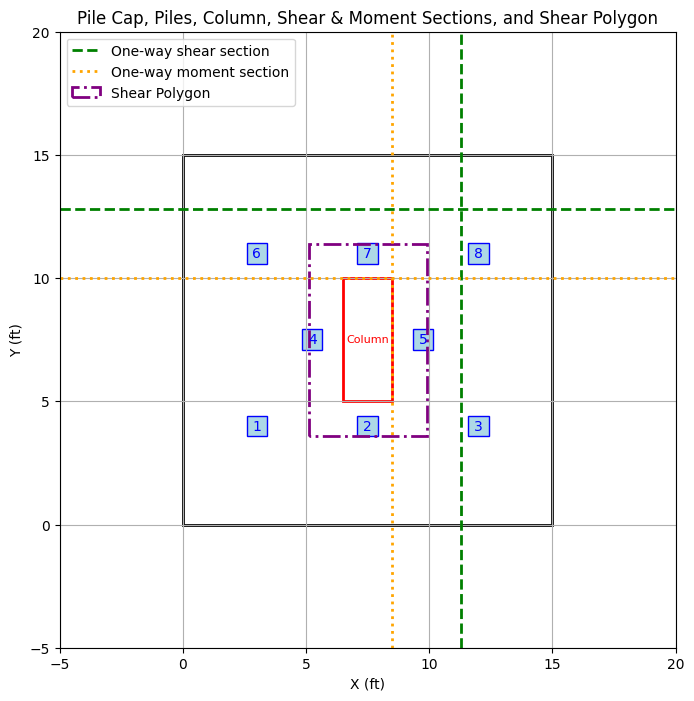

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon as MplPolygon, Rectangle

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# -------------------------------
# 1. Plot the Pile Cap
# -------------------------------
pile_cap_poly = MplPolygon(pile_cap_vertices, edgecolor='black', facecolor='none', linewidth=2)
ax.add_patch(pile_cap_poly)

# -------------------------------
# 2. Plot Each Pile
# -------------------------------
half_pile = pile_size / 2.0
for i, (px, py) in enumerate(pile_layout):
    lower_left = (px - half_pile, py - half_pile)
    pile_rect = Rectangle(lower_left, pile_size, pile_size,
                          edgecolor='blue', facecolor='lightblue', linewidth=1)
    ax.add_patch(pile_rect)
    ax.text(px, py, str(i + 1), color='blue', fontsize=10, ha='center', va='center')

# -------------------------------
# 3. Plot the Column
# -------------------------------
column_width, column_height = column_size
column_cx, column_cy = column_centroid
col_lower_left = (column_cx - column_width / 2, column_cy - column_height / 2)
column_rect = Rectangle(col_lower_left, column_width, column_height,
                        edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(column_rect)
ax.text(column_cx, column_cy, 'Column', color='red', fontsize=8, ha='center', va='center')

# -------------------------------
# Determine Plot Limits
# -------------------------------
min_x, min_y = np.min(pile_cap_vertices, axis=0)
max_x, max_y = np.max(pile_cap_vertices, axis=0)
padding = 5

# -------------------------------
# 4. Plot the One-Way Shear Section Lines
# -------------------------------

# Section 1: One-way shear section (regular line)
if one_way_shear_1_line_type == 'regular':
    m, c = one_way_shear_1_line_value
    x_vals = np.linspace(min_x - padding, max_x + padding, 100)
    y_vals = m * x_vals + c
    ax.plot(x_vals, y_vals, color='green', linestyle='--', linewidth=2,
            label='One-way shear section')
    
# Section 2: One-way shear section (vertical line)
if one_way_shear_2_line_type == 'vertical':
    x_val = one_way_shear_2_line_value[0]
    y_vals = np.linspace(min_y - padding, max_y + padding, 100)
    x_vals = np.full_like(y_vals, x_val)
    ax.plot(x_vals, y_vals, color='green', linestyle='--', linewidth=2,
            label='_nolegend_')

# -------------------------------
# 5. Plot the One-Way Moment Section Lines
# -------------------------------

# Section 1: One-way moment section (regular line)
if one_way_moment_1_line_type == 'regular':
    m, c = one_way_moment_1_line_value
    x_vals = np.linspace(min_x - padding, max_x + padding, 100)
    y_vals = m * x_vals + c
    ax.plot(x_vals, y_vals, color='orange', linestyle=':', linewidth=2,
            label='One-way moment section')
    
# Section 2: One-way moment section (vertical line)
if one_way_moment_2_line_type == 'vertical':
    x_val = one_way_moment_2_line_value[0]
    y_vals = np.linspace(min_y - padding, max_y + padding, 100)
    x_vals = np.full_like(y_vals, x_val)
    ax.plot(x_vals, y_vals, color='orange', linestyle=':', linewidth=2,
            label='_nolegend_')

# -------------------------------
# 6. Plot the Shear Polygon (Punching Shear Polygon)
# -------------------------------
# Assuming shear_polygon_coords is a list of (x, y) tuples
if 'shear_polygon_coords' in globals() and shear_polygon_coords:
    punching_shear_poly = MplPolygon(shear_polygon_coords, edgecolor='purple', facecolor='none',
                                     linewidth=2, linestyle='-.', label='Punching shear polygon')
    ax.add_patch(punching_shear_poly)

# -------------------------------
# Final Plot Settings
# -------------------------------
ax.set_xlim(min_x - padding, max_x + padding)
ax.set_ylim(min_y - padding, max_y + padding)
ax.set_aspect('equal')
ax.set_title("Pile Cap, Piles, Column, Shear & Moment Sections, and Punching Shear Polygon")
plt.xlabel("X (ft)")
plt.ylabel("Y (ft)")
plt.grid(True)
plt.legend()

plt.show()
